In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import corner

In [2]:
vit_preds = np.load("../models/20230711_vit_noisy_6_params_no_norm/preds.npy")
resnet_preds = np.load("../models/20230715_resnet_noisy_6_params_no_norm/preds.npy")
vit_labels = np.load("../models/20230711_vit_noisy_6_params_no_norm/label_ids.npy")
resnet_labels = np.load("../models/20230715_resnet_noisy_6_params_no_norm/label_ids.npy")

# vit_preds = np.mean(vit_preds[:, :, :vit_preds.shape[2]//2], axis=0)
# resnet_preds = np.mean(resnet_preds[:, :, :resnet_preds.shape[2]//2], axis=0)

(10, 1694, 12)


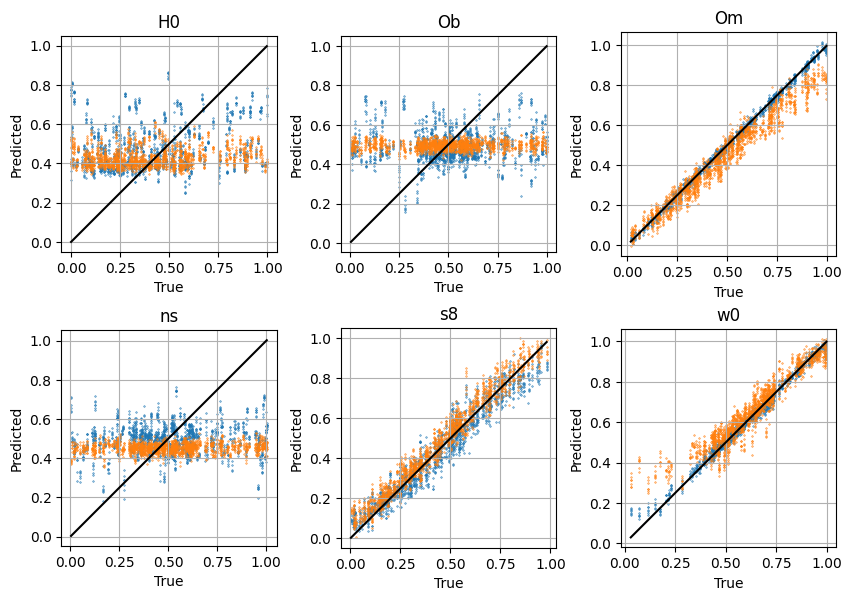

In [3]:
labels = ["H0", "Ob", "Om", "ns", "s8", "w0"]
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
# add hspace and vspace
fig.subplots_adjust(wspace=0.3, hspace=0.2)
for i in range(6):
    axs[i//3, i%3].scatter(vit_labels[:, i], vit_preds[:, i], marker="x", alpha=0.5, s=1)
    axs[i//3, i%3].scatter(resnet_labels[:, i], resnet_preds[:, i], marker="x", alpha=0.5, s=1)
    axs[i//3, i%3].plot([np.min(vit_labels[:, i]), np.max(vit_labels[:, i])], \
                        [np.min(vit_labels[:, i]), np.max(vit_labels[:, i])], c="k")
    axs[i//3, i%3].set_xlabel("True")
    axs[i//3, i%3].set_ylabel("Predicted")
    axs[i//3, i%3].set_aspect("equal")
    axs[i//3, i%3].set_title(labels[i])
    axs[i//3, i%3].grid()
plt.show()
plt.close()

In [4]:
indices = (2, 4, 5)
vit_preds, resnet_preds, vit_labels, resnet_labels = \
    vit_preds[:-1, indices], resnet_preds[:-1, indices], vit_labels[:-1, indices], resnet_labels[:-1, indices]

In [5]:
prior = utils.BoxUniform(low=np.min(vit_labels, axis=0), high=np.max(vit_labels, axis=0))
proposal = prior
inference = SNPE(prior=prior, density_estimator=utils.posterior_nn(model='maf',
                                                hidden_features=50,
                                                num_transforms=4))

theta, x = torch.FloatTensor(vit_labels), torch.FloatTensor(vit_preds)
density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
posterior_vit = inference.build_posterior(density_estimator)

proposal = prior
inference = SNPE(prior=prior, density_estimator=utils.posterior_nn(model='maf',
                                                hidden_features=50,
                                                num_transforms=4))

theta, x = torch.FloatTensor(resnet_labels), torch.FloatTensor(resnet_preds)
density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
posterior_resnet = inference.build_posterior(density_estimator)

 Neural network successfully converged after 88 epochs.

In [6]:
ind = np.random.randint(0, len(vit_labels))
ind = -1
x_0 = vit_labels[ind]
print(ind, x_0)

-1 [0.24438937 0.41730303 0.71206546]


In [7]:
posterior_samples_vit = posterior_vit.set_default_x(x_0).sample((10000,), x=x_0)
posterior_samples_resnet = posterior_resnet.set_default_x(x_0).sample((10000,), x=x_0)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

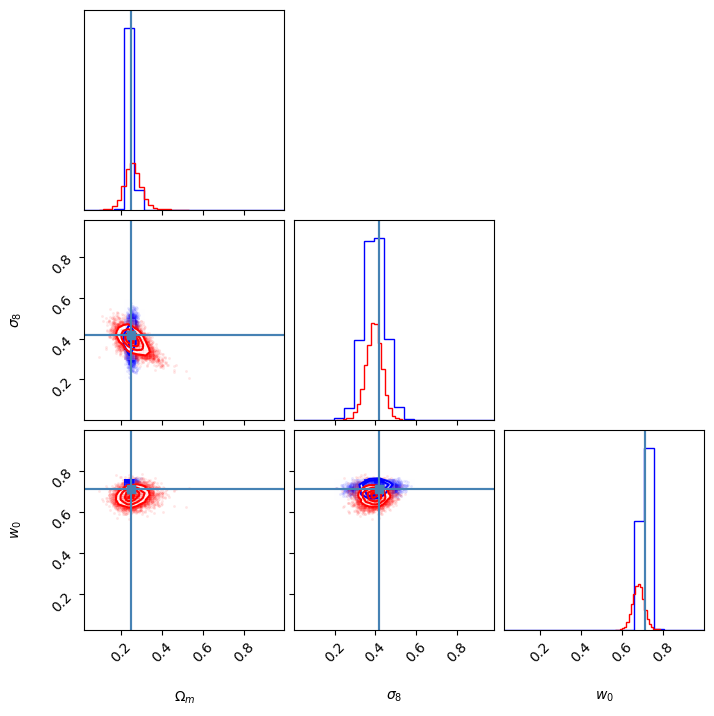

In [8]:
fig = corner.corner(np.array(posterior_samples_vit), truths=x_0, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    color="blue", range=np.array([np.min(vit_labels, axis=0), np.max(vit_labels, axis=0)]).T)
fig = corner.corner(np.array(posterior_samples_resnet), truths=x_0, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    fig=fig, color="red")

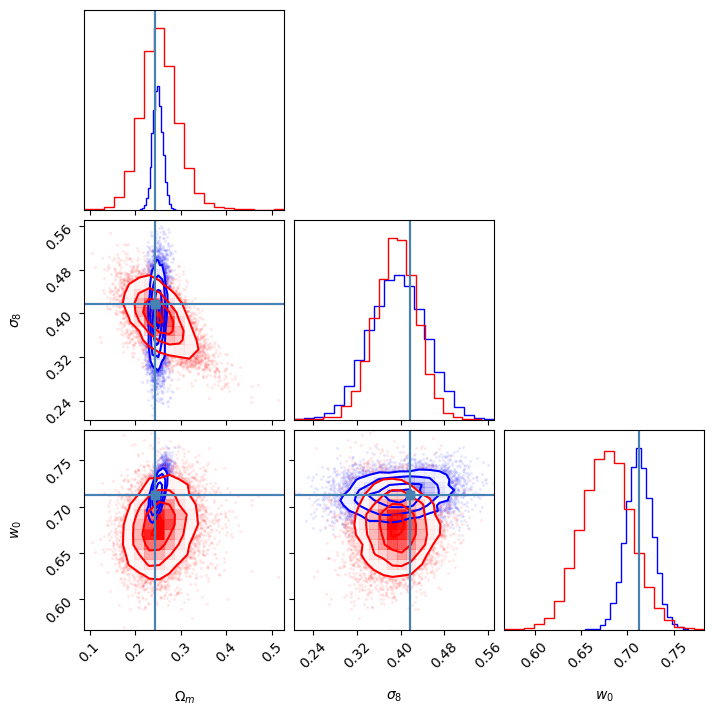

In [9]:
fig = corner.corner(np.array(posterior_samples_vit), truths=x_0, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    color="blue")
fig = corner.corner(np.array(posterior_samples_resnet), truths=x_0, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    fig=fig, color="red")